# Hyperparameter Optimisation
Autoencoder development requires a hyperparameter optimisation step. The hyperparameters adjusted for optimisation include:

1. Number of epochs for training
2. Optimiser and learning rate
3. The number of neurons in the latent space

The model uses an L2 loss function, i.e., the mean squared error (MSE) for accessing the models reproducing capacity.

In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import matplotlib.pyplot as plt

from utils import prepare_data
from build_model import AutoencoderV3
from train_model import train_autoencoder

In [2]:
# device agnostic
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# Prepare the data
DNA_meth_train = prepare_data("/content/DNAMethylation_train.csv")
DNA_meth_test = prepare_data("/content/DNAMethylation_test.csv")
RNA_seq_train = prepare_data("/content/RNAseq_train.csv")
RNA_seq_test = prepare_data("/content/RNAseq_test.csv")

# Merge
X_train = pd.merge(DNA_meth_train, RNA_seq_train, left_index=True, right_index=True)
X_test = pd.merge(DNA_meth_test, RNA_seq_test, left_index=True, right_index=True)

# Convert to tensors and send to device
X_train = torch.tensor(X_train.to_numpy(), dtype=torch.float32).to(device)
X_test = torch.tensor(X_test.to_numpy(), dtype=torch.float32).to(device)

## 1. Number of Epochs
Two models (0 and 1) were developed with the same hyperparameters and different number of neurons in the hidden layer (250 and 125 respectively) to examine the effect that increasing the number of epochs has on the train and test loss as well as overfitting.

Epoch 0/2000 | Train Loss: 0.1907 | Test Loss: 0.1908
Epoch 100/2000 | Train Loss: 0.0608 | Test Loss: 0.0635
Epoch 200/2000 | Train Loss: 0.0525 | Test Loss: 0.0561
Epoch 300/2000 | Train Loss: 0.0524 | Test Loss: 0.0560
Epoch 400/2000 | Train Loss: 0.0523 | Test Loss: 0.0559
Epoch 500/2000 | Train Loss: 0.0498 | Test Loss: 0.0536
Epoch 600/2000 | Train Loss: 0.0435 | Test Loss: 0.0483
Epoch 700/2000 | Train Loss: 0.0424 | Test Loss: 0.0475
Epoch 800/2000 | Train Loss: 0.0416 | Test Loss: 0.0469
Epoch 900/2000 | Train Loss: 0.0404 | Test Loss: 0.0458
Epoch 1000/2000 | Train Loss: 0.0381 | Test Loss: 0.0441
Epoch 1100/2000 | Train Loss: 0.0365 | Test Loss: 0.0435
Epoch 1200/2000 | Train Loss: 0.0355 | Test Loss: 0.0434
Epoch 1300/2000 | Train Loss: 0.0345 | Test Loss: 0.0434
Epoch 1400/2000 | Train Loss: 0.0335 | Test Loss: 0.0436
Epoch 1500/2000 | Train Loss: 0.0325 | Test Loss: 0.0439
Epoch 1600/2000 | Train Loss: 0.0313 | Test Loss: 0.0442
Epoch 1700/2000 | Train Loss: 0.0300 | Test

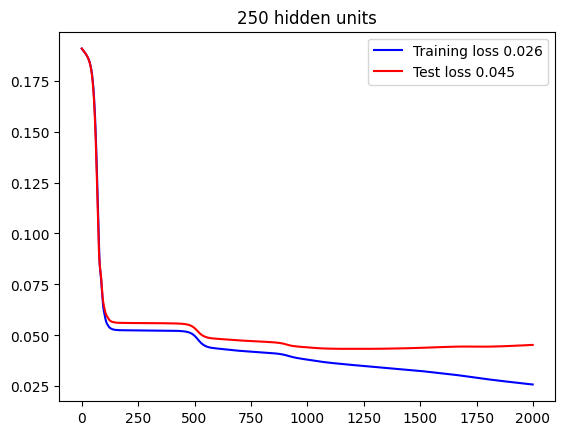

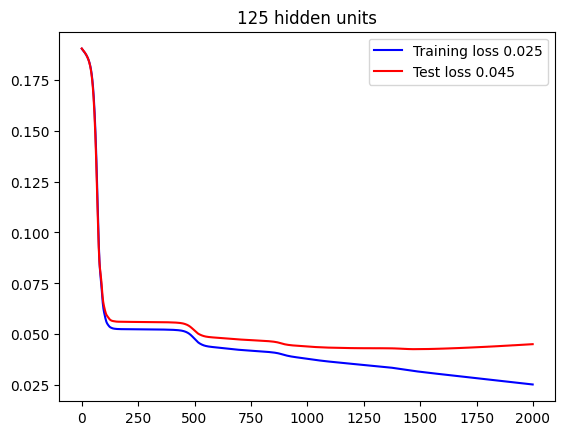

In [22]:
# 1. Number of Epochs
model_0 = AutoencoderV3(X_train.shape[1], 250).to(device)
model_1 = AutoencoderV3(X_train.shape[1], 125).to(device)

# Loss and optimizer
epochs = 2000
loss_fn = nn.MSELoss()
optimizer_0 = torch.optim.Adam(model_0.parameters(), lr=0.00001)
optimizer_1 = torch.optim.Adam(model_1.parameters(), lr=0.00001)

# Model training
model_0, train_loss_0, test_loss_0 = train_autoencoder(model=model_0, loss_fn=loss_fn, optimizer=optimizer_0, epochs=epochs, X_train=X_train, X_test=X_test, updates=True, updates_epochs=100)
model_1, train_loss_1, test_loss_1 = train_autoencoder(model=model_1, loss_fn=loss_fn, optimizer=optimizer_1, epochs=epochs, X_train=X_train, X_test=X_test, updates=True, updates_epochs=100)

# Plot
plt.plot(range(epochs), torch.Tensor(train_loss_0).cpu(), color='blue', label=f"Training loss {train_loss_0[-1]:.3f}")
plt.plot(range(epochs), torch.Tensor(test_loss_0).cpu(), color='red', label=f"Test loss {test_loss_0[-1]:.3f}")
plt.title("250 hidden units")
plt.legend()
plt.show()

plt.plot(range(epochs), torch.Tensor(train_loss_1).cpu(), color='blue', label=f"Training loss {train_loss_1[-1]:.3f}")
plt.plot(range(epochs), torch.Tensor(test_loss_1).cpu(), color='red', label=f"Test loss {test_loss_1[-1]:.3f}")
plt.title("125 hidden units")
plt.legend()
plt.show()

## 2. Optimizer Comparison

Model 1 was used to compare four different optimizers - Adam, SGD, RMSprop, and Adagrad. All other hyperparameters were kept constant (lr = 0.00001, 1000 epochs)

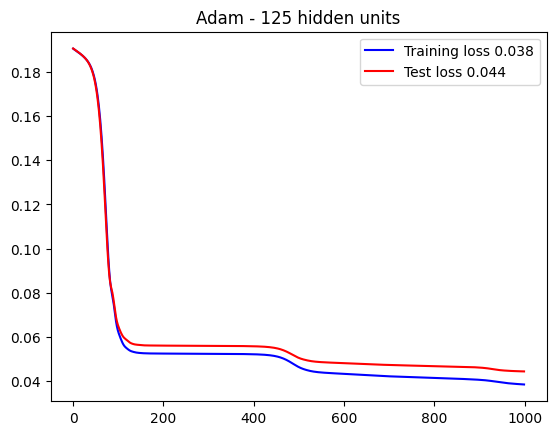

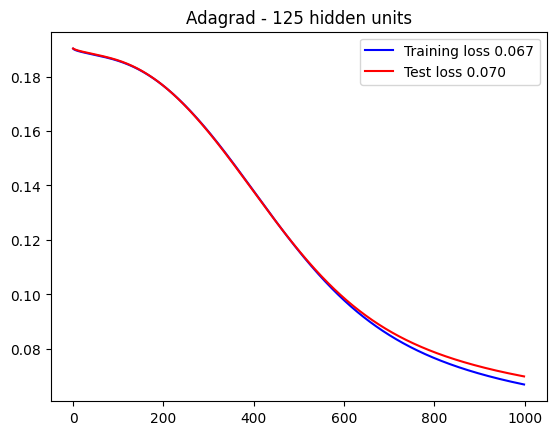

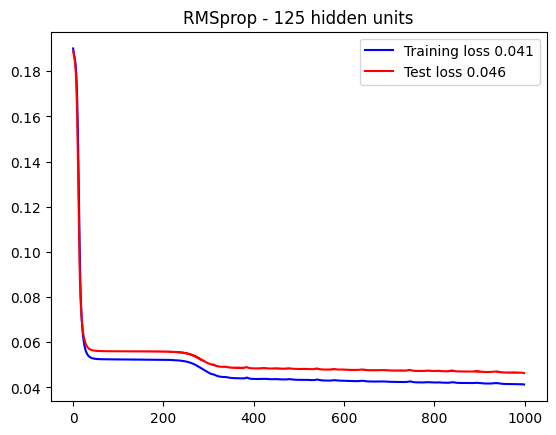

In [10]:
# 2. Optimizer Comparison

optimizers = ["Adam", "Adagrad", "RMSprop"]

epochs = 1000
loss_fn = nn.MSELoss()

for opt in optimizers:
    model = AutoencoderV3(X_train.shape[1], 125).to(device)

    match opt:
        case "Adam":
            optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
        case "Adagrad":
            optimizer = torch.optim.Adagrad(model.parameters(), lr=0.00001)
        case "RMSprop":
            optimizer = torch.optim.RMSprop(model.parameters(), lr=0.00001)
        case _:
            raise ValueError(f"Unknown optimizer: {opt}")

    # Train the model
    model, train_loss, test_loss = train_autoencoder(
        model=model, loss_fn=loss_fn, optimizer=optimizer,
        epochs=epochs, X_train=X_train, X_test=X_test,
        updates=False, updates_epochs=100
    )

    # Plot the loss curves
    plt.plot(range(epochs), torch.Tensor(train_loss).cpu(), color='blue', label=f"Training loss {train_loss[-1]:.3f}")
    plt.plot(range(epochs), torch.Tensor(test_loss).cpu(), color='red', label=f"Test loss {test_loss[-1]:.3f}")
    plt.title(f"{opt} - 125 hidden units")
    plt.legend()
    plt.show()

## 3. Number of Neurons in Latent Space

In [15]:
# 3. Number of Neurons in Latent Space

train_losses_average = []
test_losses_average = []

for i in range(20):
  train_losses = []
  test_losses = []

  for neurons in range(25, 500, 100):
    model_3 = AutoencoderV3(X_train.shape[1], neurons).to(device)

    # Loss and optimizer
    epochs = 400
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.RMSprop(model_1.parameters(), lr=0.00001)

    # Model training
    model_3, train_loss, test_loss = train_autoencoder(model=model_3, loss_fn=loss_fn, optimizer=optimizer, epochs=epochs, X_train=X_train, X_test=X_test, updates=False, updates_epochs=200)

    train_losses.append(train_loss[-1])
    test_losses.append(test_loss[-1])

  train_losses_average.append(train_losses)
  test_losses_average.append(test_losses)

  print(f"{i+1}/20 complete")

1/20 complete
2/20 complete
3/20 complete
4/20 complete
5/20 complete
6/20 complete
7/20 complete
8/20 complete
9/20 complete
10/20 complete
11/20 complete
12/20 complete
13/20 complete
14/20 complete
15/20 complete
16/20 complete
17/20 complete
18/20 complete
19/20 complete
20/20 complete


In [16]:
np.save("train_losses.npy", train_losses_average)
np.save("test_losses.npy", test_losses_average)

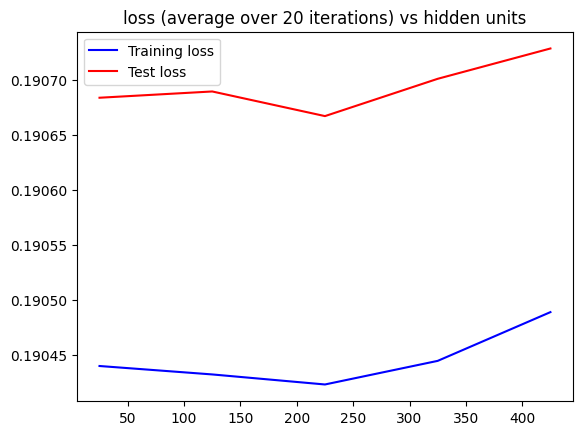

In [21]:
# plot
av_trl = np.mean(np.array(train_losses_average), axis=0)
av_tel = np.mean(np.array(test_losses_average), axis=0)
plt.plot(range(25, 450, 100), av_trl, color='blue', label="Training loss")
plt.plot(range(25, 450, 100), av_tel, color='red', label="Test loss")
plt.title("loss (average over 20 iterations) vs hidden units")
plt.legend()
plt.show()